%%html
<a href="https://colab.research.google.com/github/amir-jafari/SOM/blob/main/examples/Tabular/Iris/notebook/iris_post_training_analysis.ipynb" target="_blank">
  <button style="color: white; background-color: #1a73e8; padding: 10px; border: none; text-align: center; text-decoration: none; display: inline-block; font-size: 16px; margin: 4px 2px; cursor: pointer; border-radius: 8px;">
    Open in Colab
  </button>
</a>


In this notebook we will see how to use NNSOM with Iris dataset for post-training analysis.

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

#if IN_COLAB:
    # Install NNSOM
!pip install --upgrade NNSOM

  Using cached nnsom-1.5.9-py3-none-any.whl (25 kB)
  Attempting uninstall: NNSOM
    Found existing installation: NNSOM 1.5.8
    Uninstalling NNSOM-1.5.8:
      Successfully uninstalled NNSOM-1.5.8


In [2]:
from NNSOM.plots import SOMPlots
from NNSOM.utils import *

Load the pre-trained SOM model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os

model_path = "/content/drive/MyDrive/Colab Notebooks/NNSOM/Examples/Iris/"
trianed_file_name = "SOM_Model_iris_Epoch_500_Seed_1234567_Size_4.pkl"

# SOM Parameters
SOM_Row_Num = 4  # The number of row used for the SOM grid.
Dimensions = (SOM_Row_Num, SOM_Row_Num) # The dimensions of the SOM grid.

som = SOMPlots(Dimensions)
som = som.load_pickle(trianed_file_name, model_path)

Data Preparation

In [5]:
from sklearn.datasets import load_iris
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Random State
from numpy.random import default_rng
SEED = 1234567
rng = default_rng(SEED)

# Data Preprocessing
iris = load_iris()
X = iris.data
y = iris.target

X = X[rng.permutation(len(X))]
y = y[rng.permutation(len(X))]

scaler = MinMaxScaler(feature_range=(-1, 1))

Extract SOM Cluster Details

In [6]:
clust, dist, mdist, clustSizes = som.cluster_data(X)

Train the classifier with Iris dataset

In [7]:
# Train Logistic Regression on Iris
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state=SEED)
logit.fit(X, y)
results = logit.predict(X)

# Visualization

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preprocessing

In [9]:
perc_misclassified = get_perc_misclassified(y, results, clust)

# For Pie chart and Stem Plot
sent_tp, sent_tn, sent_fp, sent_fn = get_conf_indices(y, results, 0)  # Confusion matrix for sentosa
sentosa_conf = cal_class_cluster_intersect(clust, sent_tp, sent_tn, sent_fp, sent_fn)
vers_tp, vers_tn, vers_fp, vers_fn = get_conf_indices(y, results, 1)  # Confusion matrix for versicolor
versicolor_conf = cal_class_cluster_intersect(clust, vers_tp, vers_tn, vers_fp, vers_fn)
virg_tp, virg_tn, virg_fp, virg_fn = get_conf_indices(y, results, 2)  # Confusion matrix for virginica
virginica_conf = cal_class_cluster_intersect(clust, virg_tp, virg_tn, virg_fp, virg_fn)
conf_align = [0, 1, 2, 3]

# Complex Hit Histogram
# Get the list with dominat class in each cluster
dominant_classes = majority_class_cluster(y, clust)

# Get the majority error type (0: type 1 error, 1: type 2 error) corresponding dominat class
sent_error = get_color_labels(clust, sent_tn, sent_fp)  # Get the majority error type in sentosa
vers_error = get_color_labels(clust, vers_tn, vers_fp)  # Get the majority error type in versicolor
virg_error = get_color_labels(clust, virg_tn, virg_fp)  # Get the majority error type in virginica
iris_error_types = [sent_error, vers_error, virg_error]
error_types = get_dominant_class_error_types(dominant_classes, iris_error_types)

# Get the edge width based on the perc of misclassified
ind_misclassified = get_ind_misclassified(y, results)
edge_width = get_edge_widths(ind_misclassified, clust)

# Make an additional 2-D array
comp_2d_array = np.transpose(np.array([dominant_classes, error_types, edge_width]))

# Simple Grid
perc_sentosa = get_perc_cluster(y, 0, clust)
simple_2d_array = np.transpose(np.array([perc_sentosa, perc_sentosa]))

data_dict = {
    "data": X,
    "target": y,
    "clust": clust,
    "add_1d_array": perc_misclassified,
    "add_2d_array": []
}

## Grey Hist

Brighter: More

Darker: Less

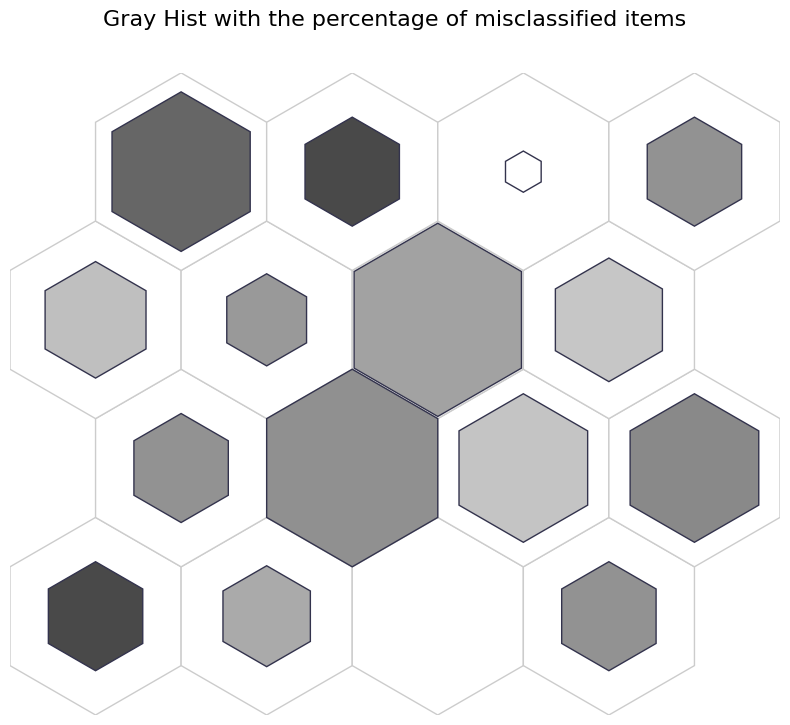

In [10]:
fig, ax, patches, text = som.plot('gray_hist', data_dict, use_add_array=True)
plt.suptitle("Gray Hist with the percentage of misclassified items", fontsize=16)
plt.show()

## Color hist

The color colose to red indicates more likely to be misclassified.

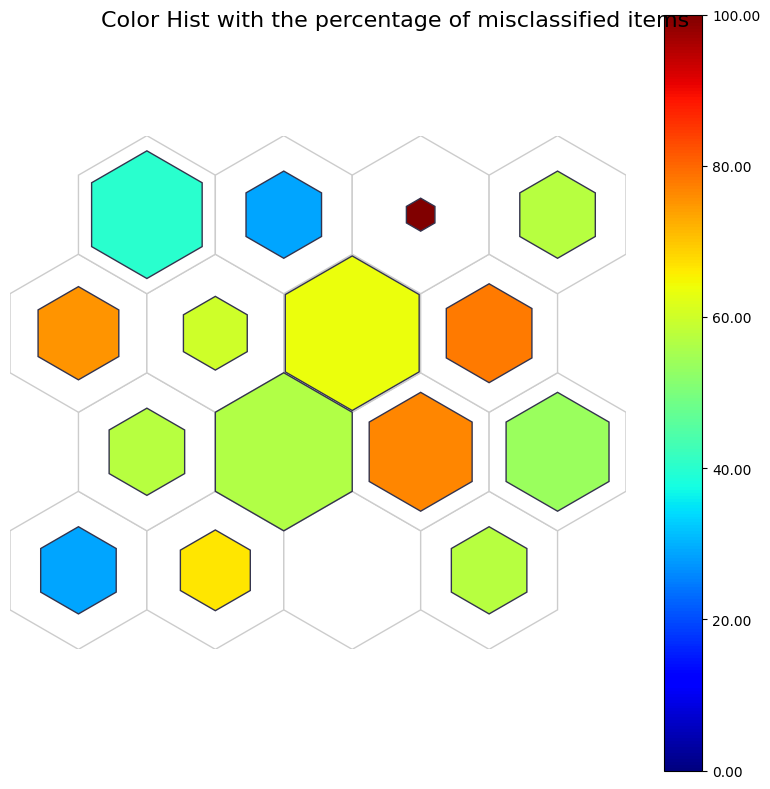

In [11]:
fig, ax, patches, text, cbar = som.plot('color_hist', data_dict, use_add_array=True)
plt.suptitle("Color Hist with the percentage of misclassified items", fontsize=16)
plt.show()

## Complex hit hist

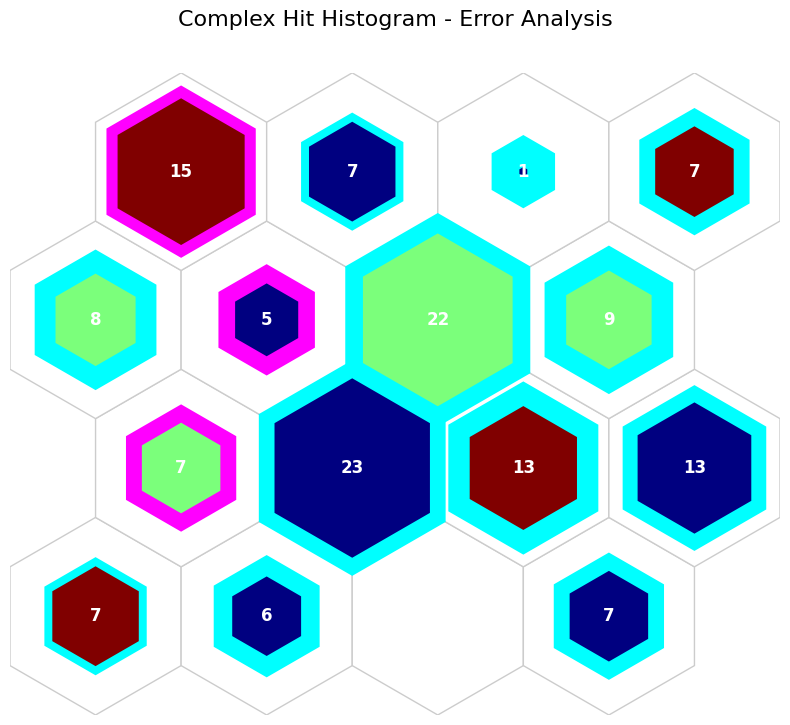

In [12]:
# sentosa: Blue, versicolor: Green, virginica: Red (inner color)
# type 1 error (tn): Pink, type 2 error (fn): blue (edge color) for corresponding dominat classes
# Edge width: percentage of misclassified items (edge width)
data_dict['add_2d_array'] = comp_2d_array  # Update an additional 2-D array
fig, ax, patches, text = som.plot('complex_hist', data_dict, use_add_array=True)
plt.suptitle("Complex Hit Histogram - Error Analysis", fontsize=16)
plt.show()

## Simple grid

color: misclassified percentages

size: the number of sentosa

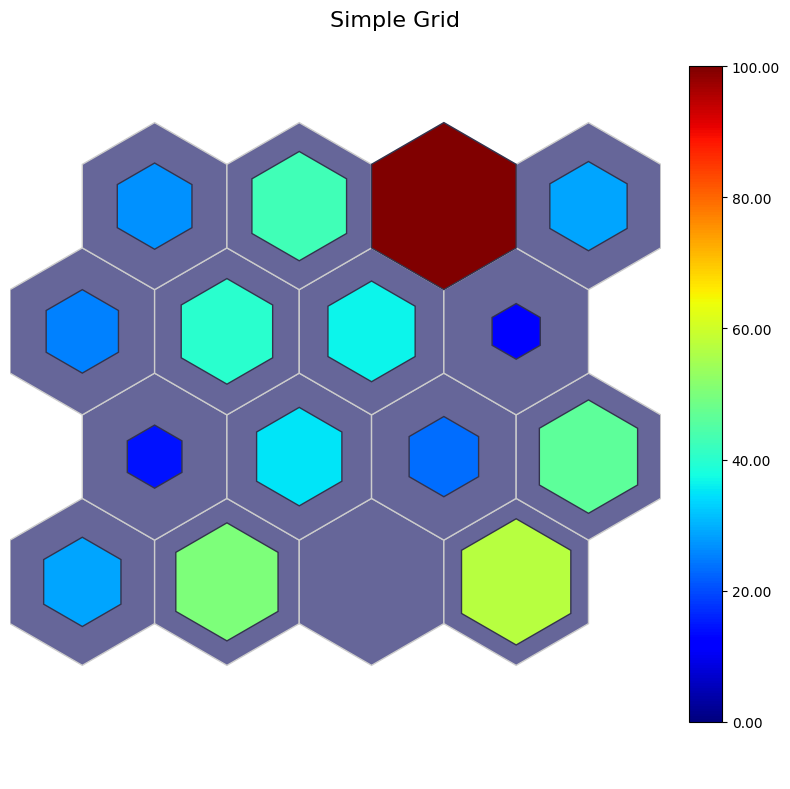

In [13]:
# color: perc misclassified
# sizes: perc sentosa
data_dict['add_2d_array'] = simple_2d_array  # Update an additional 2-D array

fig, ax, patches, cbar = som.plot('simple_grid', data_dict, use_add_array=True)
plt.suptitle("Simple Grid", fontsize=16)
plt.show()

## Pie Chart

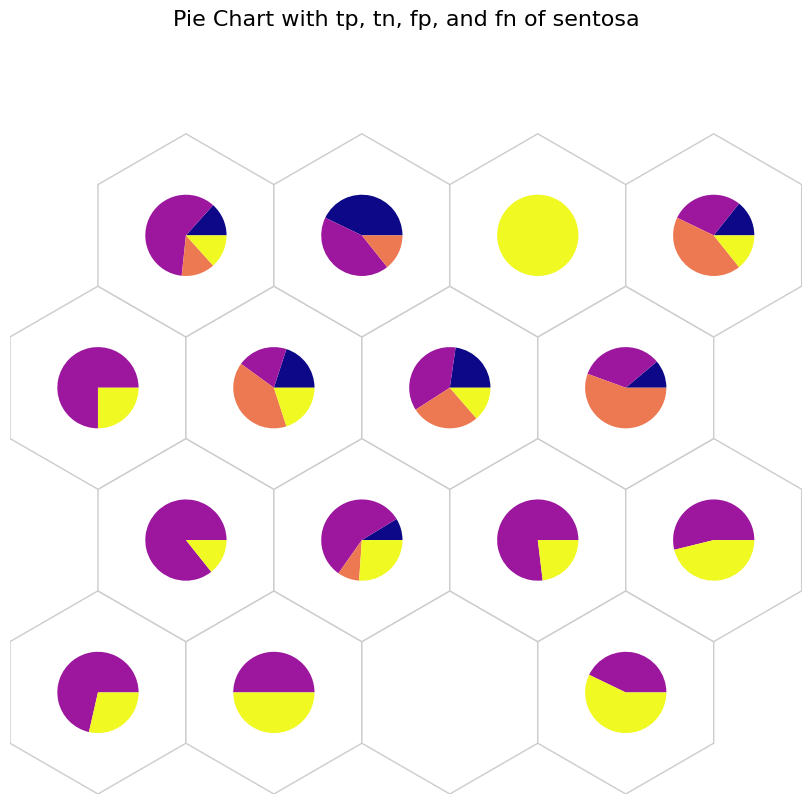

In [14]:
# tp: Blue, tn: Purple, fp: Orange, and fn: Yellow
data_dict['add_2d_array'] = sentosa_conf  # Update an additional 2-D array
fig, ax, h_axes = som.plot('pie', data_dict, use_add_array=True)
plt.suptitle("Pie Chart with tp, tn, fp, and fn of sentosa", fontsize=16)
plt.show()

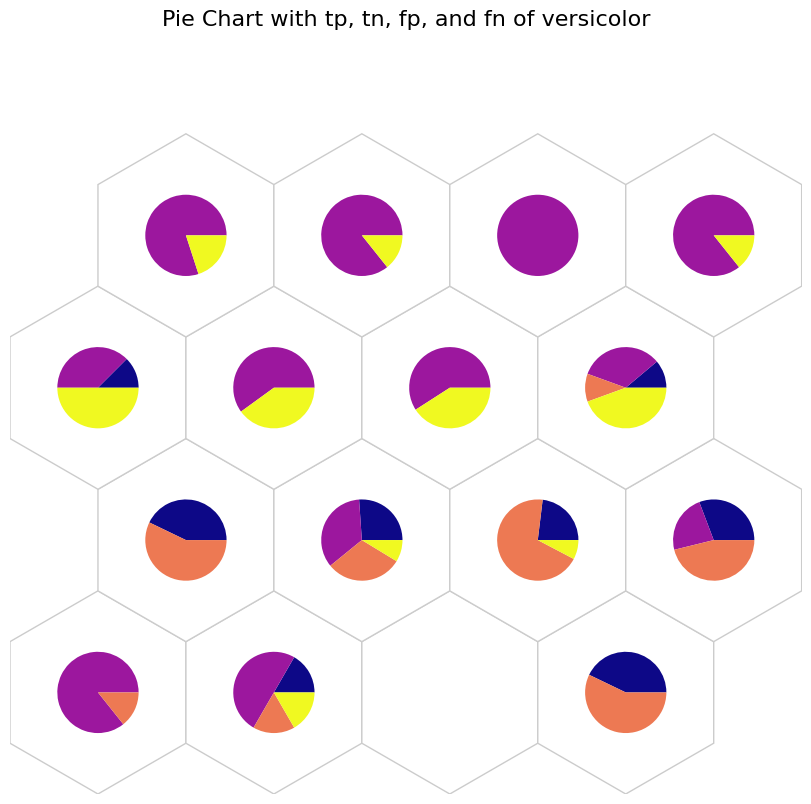

In [15]:
# tp: Blue, tn: Purple, fp: Orange, and fn: Yellow
data_dict['add_2d_array'] = versicolor_conf # Update an additional 2-D array
fig, ax, h_axes = som.plot('pie', data_dict, use_add_array=True)
plt.suptitle("Pie Chart with tp, tn, fp, and fn of versicolor", fontsize=16)
plt.show()

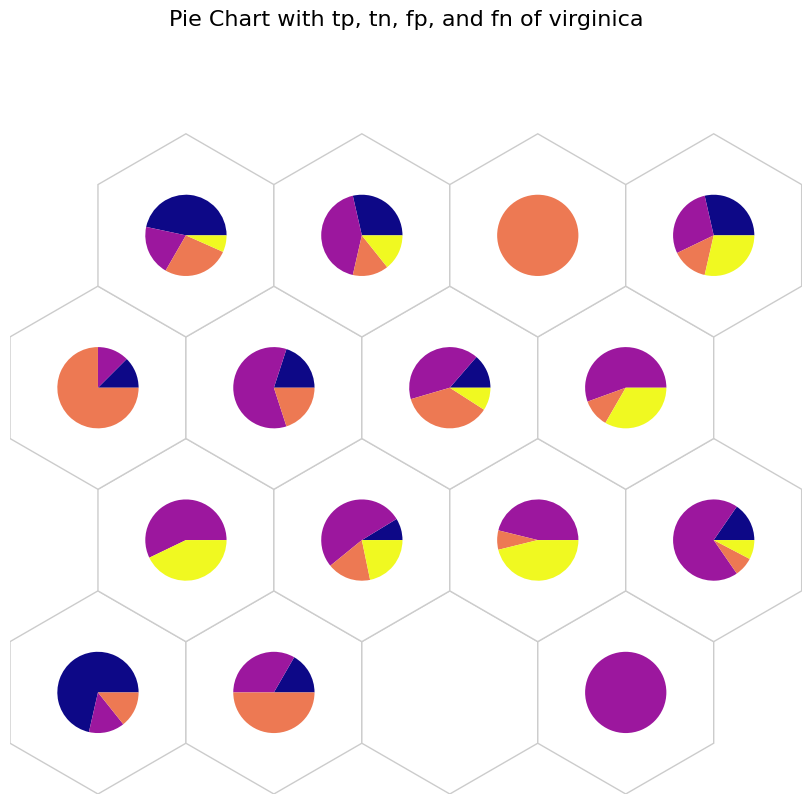

In [16]:
# tp: Blue, tn: Purple, fp: Orange, and fn: Yellow
data_dict['add_2d_array'] = virginica_conf  # Update an additional 2-D array
fig, ax, h_axes = som.plot('pie', data_dict, use_add_array=True)
plt.suptitle("Pie Chart with tp, tn, fp, and fn of virginica", fontsize=16)
plt.show()

## Stem Plot


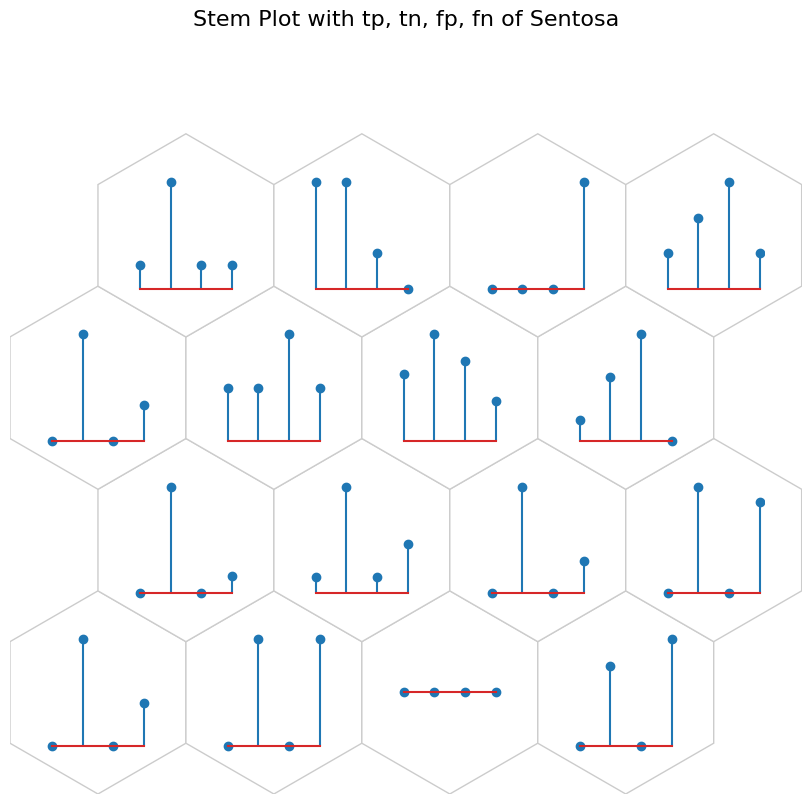

In [17]:
data_dict['add_2d_array'] = sentosa_conf  # Update an additional 2-D array
fig, ax, h_axes = som.plot("stem", data_dict, use_add_array=True)
plt.suptitle("Stem Plot with tp, tn, fp, fn of Sentosa", fontsize=16)
plt.show()

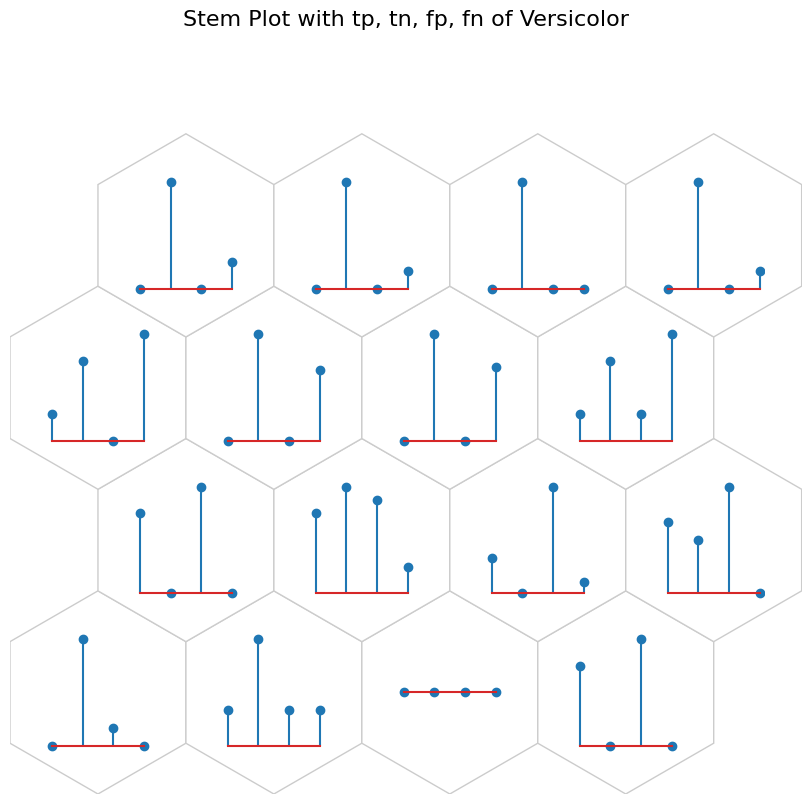

In [18]:
data_dict['add_2d_array'] = versicolor_conf # Update an additional 2-D array
fig, ax, h_axes = som.plot("stem", data_dict, use_add_array=True)
plt.suptitle("Stem Plot with tp, tn, fp, fn of Versicolor", fontsize=16)
plt.show()

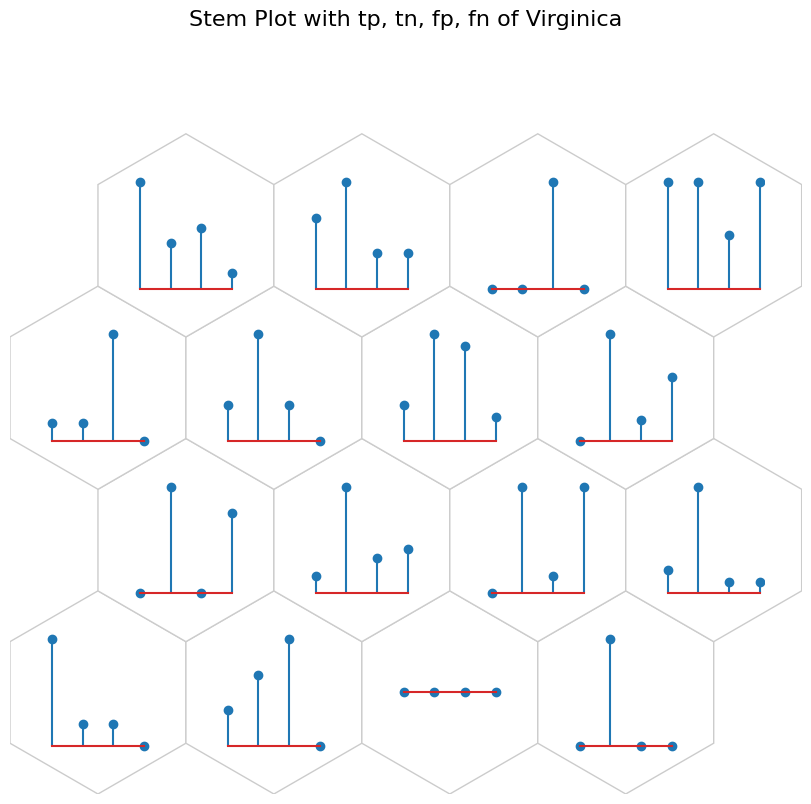

In [19]:
data_dict['add_2d_array'] = virginica_conf  # Update an additional 2-D array
fig, ax, h_axes = som.plot("stem", data_dict, use_add_array=True)
plt.suptitle("Stem Plot with tp, tn, fp, fn of Virginica", fontsize=16)
plt.show()